In [37]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# 载入数据

In [2]:
mnist=keras.datasets.mnist

In [3]:
(x_trains,y_trains),(x_test,y_test)=mnist.load_data()

In [4]:
x_trains.shape

(60000, 28, 28)

In [5]:
x_trains.dtype

dtype('uint8')

In [6]:
type(x_trains)

numpy.ndarray

In [207]:
x_valid,x_train=x_trains[:5000]/255.0,x_trains[5000:]/255.0   # 255是像素强度，等价于将像素强度压缩到0-1
y_valid,y_train=y_trains[:5000]/255.0,y_trains[5000:]/255.0

# 将数据转为tensor

In [208]:
x_valid=tf.constant(x_valid)
x_train=tf.constant(x_train)
x_test=tf.constant(x_test)
y_valid=tf.constant(y_valid)
y_train=tf.constant(y_train)
y_test=tf.constant(y_test)

In [209]:
x_train

<tf.Tensor: shape=(55000, 28, 28), dtype=float64, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0

# 定义采样层

In [9]:
K=keras.backend

In [10]:
class Sampling(keras.layers.Layer):
    def call(self,inputs):
        mean,log_var=inputs
        return K.random_normal(tf.shape(log_var))*K.exp(log_var/2)+mean

## 定义编码器

In [210]:
codings_size=10
encoder_inputs=keras.layers.Input(shape=[28,28,1])
z=keras.layers.Flatten(input_shape=[28,28])(encoder_inputs)
z=keras.layers.Dense(100,activation='relu')(z)
z=keras.layers.Dense(100,activation='relu')(z)
codings_mean=keras.layers.Dense(codings_size)(z)  # 计算μ
codings_log_var=keras.layers.Dense(codings_size)(z)  # 计算γ=log(σ^2)
codings=Sampling()([codings_mean,codings_log_var])
variational_encoder=keras.Model(inputs=[encoder_inputs],outputs=[codings_mean,codings_log_var,codings])


## 定义解码器

In [211]:
decoder_inputs=keras.layers.Input(shape=[codings_size])
x=keras.layers.Dense(100,activation='relu')(decoder_inputs)
x=keras.layers.Dense(100,activation='relu')(x)
x=keras.layers.Dense(28*28,activation='sigmoid')(x)
decoder_outputs=keras.layers.Reshape([28,28,1])(x)
variational_decoder=keras.Model(inputs=[decoder_inputs],outputs=[decoder_outputs])

## 整合变分自编码器

In [212]:
_,_,codings=variational_encoder(encoder_inputs)
reconstruction=variational_decoder(codings)
VAE=keras.Model(inputs=[encoder_inputs],outputs=[reconstruction])

## 定义潜在损失和重构损失

In [213]:
latent_loss=-0.5*K.sum(1+codings_log_var-K.exp(codings_log_var)-K.square(codings_mean))
VAE.add_loss(K.mean(latent_loss)/784.0)

## 定义优化策略和损失函数

In [214]:
VAE.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss='mse')

In [215]:
y_train.shape

TensorShape([55000])

## 训练模型

In [221]:
K.clear_session()
history=VAE.fit(x_train,y_train,epochs=5,batch_size=1,validation_data=(x_valid,y_valid))

Epoch 1/5
55000/55000 [==============================] - 163s 3ms/step - loss: 1.3838e-04 - val_loss: 1.3027e-04
Epoch 2/5
55000/55000 [==============================] - 167s 3ms/step - loss: 1.3213e-04 - val_loss: 1.3011e-04
Epoch 3/5
55000/55000 [==============================] - 165s 3ms/step - loss: 1.3176e-04 - val_loss: 1.3236e-04
Epoch 4/5
55000/55000 [==============================] - 141s 3ms/step - loss: 1.3127e-04 - val_loss: 1.2795e-04
Epoch 5/5
55000/55000 [==============================] - 135s 2ms/step - loss: 1.3123e-04 - val_loss: 1.2909e-04


In [218]:
VAE.evaluate(x_test,y_test,batch_size=1)

10000/10000 [==============================] - 21s 2ms/step - loss: 28.0605


28.060462951660156

In [1]:
def plot_image(image):
    plt.imshow(image,cmap='gray')
    plt.axis('off')

def show_reconstrution(model,n_image=5):
    reconstruction=model.predict(x_test[:n_image].numpy().reshape(28,28))
    fig=plt.figure(figsize=(n_image*1.5,3))
    for i in range(n_image):
        plt.subplot(2,n_image,1+i)
        plot_image(x_test[i])
        plt.subplot(2,n_image,1+n_image+i)
        plot_image(reconstruction[i])
        

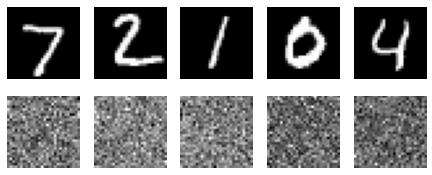

In [220]:
show_reconstrution(VAE)